# A quick binding free energy calculation of K$^+$ and Cl$^-$ using pAPRika

David Slochower, March 27, 2019

**This notebook will run `sander` calculations in real-time on mybinder.org. This will take less than five minutes.**

## Preamble

- I intend this code to be run on [Binder](https://mybinder.org/), which should host a Docker image of [`pAPRika`](https://github.com/slochower/pAPRika), the initial coordinates for this calculation, and results from a reference calculation.

- This is brief run through of how a calculation might be done, if you are really in a really really in a hurry. These are not *best practices*!

I have omitted a description of the theory behind the attach-pull-release method. For further information, please see the following references: 

1. A. T. Fenley, N. M. Henriksen, H. S. Muddana, M. K. Gilson, Bridging Calorimetry and Simulation through Precise Calculations of Cucurbituril-Guest Binding Enthalpies. J. Chem. Theory Comput. 10, 4069–4078 (2014).

2. N. M. Henriksen, M. K. Gilson, Evaluating Force Field Performance in Thermodynamic Calculations of Cyclodextrin Host-Guest Binding: Water Models, Partial Charges, and Host Force Field Parameters. J. Chem. Theory Comput. 13, 4253–4269 (2017).

3. J. Yin, A. T. Fenley, N. M. Henriksen, M. K. Gilson, Toward Improved Force-Field Accuracy through Sensitivity Analysis of Host-Guest Binding Thermodynamics. J. Phys. Chem. B. 119, 10145–10155 (2015).

4. N. M. Henriksen, A. T. Fenley, M. K. Gilson, Computational Calorimetry: High-Precision Calculation of Host-Guest Binding Thermodynamics. J. Chem. Theory Comput. 11, 4377–4394 (2015).

Especially reference 4, which has additional details about the K$^+$-Cl$^-$ calculation.

Okay, let's see how to calculate the binding free energy between two monovalent ions in a water box.

In [1]:
import os
import re
import shutil
import json

import numpy as np
import parmed as pmd

from paprika import align
from paprika import amber
from paprika import analysis
from paprika import io
from paprika import log
from paprika import restraints
from paprika import tleap

In [2]:
import glob
import matplotlib.pyplot as plt
import pytraj as pt
from pmf import plot_pmf

%matplotlib inline

In [3]:
log.config_root_logger(verbose=False)

# Specify the directory containing the initial coordinates

In this case, we have a simple `pdb` file with two atoms placed 2.65 Å apart. In other cases, we might need `mol2` or `frcmod` files to begin the calculation.

In [4]:
k_cl_pdb = os.path.abspath(os.path.join("data", "k-cl.pdb"))

# Setup the calculation by building input files and umbrella sampling windows

## Build the vacuum `prmtop` and `inpcrd` files

In [5]:
sys = tleap.System()
sys.template_lines = [
    "source leaprc.water.tip3p",
    "loadamberparams frcmod.ionsjc_tip3p",
    f"model = loadpdb {k_cl_pdb}",
]

sys.output_path = "k-cl"
sys.output_prefix = "k-cl"
sys.pbc_type = None
sys.target_waters = None
sys.neutralize = False
sys.build()

## Specify the number of windows for the umbrella sampling

This will setup 5 attach windows and 10 pull windows.

The `attach_fractions` specifies $\lambda$ values for the force constant. So $\lambda = 0$ means the restraints are off and $\lambda = 1$ means the restraints are at full blast (i.e., they have achieved the maximum force constant configured).

The `pull_distances` are evenly spaced from 2.65 Å to 18.65 Å. Fewer windows means the force constant for the pulling phase should be relatively weak so that there is overlap between $\lambda$ windows.

There is no explicit release phase in this calculation but there is an analytical release phase so that we end up with $\Delta G$ relative to standard state.

In [6]:
attach_fractions = np.linspace(0, 1.0, 5)
initial_distance = 2.65
pull_distances = np.linspace(0 + initial_distance, 16.0 + initial_distance, 10)

## Add a single distance restraint between K+ and Cl-

In [7]:
restraint = restraints.DAT_restraint()
restraint.continuous_apr = True
restraint.amber_index = True
restraint.topology = k_cl_pdb
restraint.mask1 = "@K+"
restraint.mask2 = "@Cl-"

restraint.attach["target"] = initial_distance
restraint.attach["fraction_list"] = attach_fractions
restraint.attach["fc_final"] = 5.0

restraint.pull["fc"] = restraint.attach["fc_final"]
restraint.pull["target_list"] = pull_distances

restraint.initialize()

2019-03-28 08:28:13,906: Loaded /Users/dslochower/Documents/projects/paprika-kcl/data/k-cl.pdb...
2019-03-28 08:28:13,906: Loaded /Users/dslochower/Documents/projects/paprika-kcl/data/k-cl.pdb...
2019-03-28 08:28:13,995: Loaded /Users/dslochower/Documents/projects/paprika-kcl/data/k-cl.pdb...
2019-03-28 08:28:13,995: Loaded /Users/dslochower/Documents/projects/paprika-kcl/data/k-cl.pdb...


## Create the directories for each window and write the restraint input file

This makes it easy to run each window in parallel as a separate simulation. But since we are in the cloud, we will end up running in serial.

In [8]:
windows_directory = os.path.join("k-cl", "windows")

In [9]:
window_list = restraints.create_window_list([restraint])
for window in window_list:
    if os.path.exists(os.path.join(windows_directory, window)):
        continue
    else:
        os.makedirs(os.path.join(windows_directory, window))

2019-03-28 08:28:14,036: Restraints appear to be consistent
2019-03-28 08:28:14,036: Restraints appear to be consistent


In [10]:
for window in window_list:
    with open(os.path.join(windows_directory, window, "disang.rest"), "a") as file:
        string = restraints.amber_restraint_line(restraint, window)
        if string is not None:
            file.write(string)

## Set the initial distance of the ions in each window

In [11]:
for window in window_list:
    if window[0] == "a":
        structure = pmd.load_file(os.path.join("k-cl", "k-cl.prmtop"), 
                                  os.path.join("k-cl", "k-cl.rst7"), structure=True)
        for atom in structure.atoms:
            if atom.name == "Cl-":
                atom.xz = 2.65
        structure.save(os.path.join(windows_directory, window, "k-cl.prmtop"), overwrite=True)
        structure.save(os.path.join(windows_directory, window, "k-cl.rst7"), overwrite=True)
        structure.save(os.path.join(windows_directory, window, "k-cl.pdb"), overwrite=True)


    elif window[0] == "p":
        structure = pmd.load_file(os.path.join("k-cl", "k-cl.prmtop"), 
                                  os.path.join("k-cl", "k-cl.rst7"), structure=True)
        target_difference = (
            restraint.phase["pull"]["targets"][int(window[1:])]
            - restraint.phase["pull"]["targets"][0]
        )
        print(
            f"In window {window} we will translate the guest {target_difference:0.1f} Angstroms."
        )
        for atom in structure.atoms:
            if atom.name == "Cl-":
                atom.xz += target_difference
        structure.save(os.path.join(windows_directory, window, "k-cl.prmtop"), overwrite=True)
        structure.save(os.path.join(windows_directory, window, "k-cl.rst7"), overwrite=True)
        structure.save(os.path.join(windows_directory, window, "k-cl.pdb"), overwrite=True)


In window p000 we will translate the guest 0.0 Angstroms.
In window p001 we will translate the guest 1.8 Angstroms.
In window p002 we will translate the guest 3.6 Angstroms.
In window p003 we will translate the guest 5.3 Angstroms.
In window p004 we will translate the guest 7.1 Angstroms.
In window p005 we will translate the guest 8.9 Angstroms.
In window p006 we will translate the guest 10.7 Angstroms.
In window p007 we will translate the guest 12.4 Angstroms.
In window p008 we will translate the guest 14.2 Angstroms.
In window p009 we will translate the guest 16.0 Angstroms.


## Solvate the structure in each window to the same number of waters

In [12]:
for window in window_list:
    print(f"Solvating window {window}...")

    if os.path.exists(os.path.join(windows_directory, window, "k-cl-sol.prmtop")):
        print("Skipping...")
        continue


    structure = pmd.load_file(
        os.path.join(windows_directory, window, "k-cl.prmtop"),
        os.path.join(windows_directory, window, "k-cl.rst7"),
        structure=True,
    )

    system = tleap.System()
    system.output_path = os.path.join(windows_directory, window)
    system.output_prefix = "k-cl-sol"

    system.target_waters = 2000
    system.neutralize = False
    system.template_lines = ["source leaprc.water.tip3p", "model = loadpdb k-cl.pdb"]
    system.build()

Solvating window a000...
Skipping...
Solvating window a001...
Skipping...
Solvating window a002...
Skipping...
Solvating window a003...
Skipping...
Solvating window p000...
Skipping...
Solvating window p001...
Skipping...
Solvating window p002...
Skipping...
Solvating window p003...
Skipping...
Solvating window p004...
Skipping...
Solvating window p005...
Skipping...
Solvating window p006...
Skipping...
Solvating window p007...
Skipping...
Solvating window p008...
Skipping...
Solvating window p009...
Skipping...


## Tweak some parameters, like changing the charge of K$^+$ to 1.3 and Cl$^-$ to -1.3

Because K$^+$ and Cl$^-$ don't stick very tightly, let's increase their electrostatic attraction. This, again, is following reference [4] at the top of the page.

In [13]:
for window in window_list:
    structure = pmd.load_file(
        os.path.join(windows_directory, window, "k-cl-sol.prmtop"),
        os.path.join(windows_directory, window, "k-cl-sol.rst7"),
        structure=True,
    )
    for atom in structure.atoms:
        if atom.name == "Cl-":
            atom.charge = -1.3
        elif atom.name == "K+":
            atom.charge = 1.3
            
    structure.save(os.path.join(windows_directory, window, "k-cl-sol.prmtop"), overwrite=True)
    structure.save(os.path.join(windows_directory, window, "k-cl-sol.rst7"), overwrite=True)

# Run the calculation

Normalize we'd minimize and thermalize and equilibrate, but I'm skipping all that right now.

We have a few helper functions -- like `_config_pbc_min()` and `_config_pbc_md()` -- that help setup some smart defaults for AMBER. The simulations can either be run directly, as indicated below, with `simulation.run()` or the input file can be written using `_amber_write_input_file()` and then wrapped using a cluster script (like PBS or whatever).

Since we are running on the cloud, we'll just do things in serial.

In [14]:
for window in window_list:
    simulation = amber.Simulation()
    simulation.executable = "sander"

    simulation.path = os.path.join(windows_directory, window)
    simulation.prefix = "production"

    simulation.inpcrd = "k-cl-sol.rst7"
    simulation.ref = "k-cl-sol.rst7"
    simulation.topology = "k-cl-sol.prmtop"
    simulation.restraint_file = "disang.rest"

    simulation.config_pbc_md()
    simulation.cntrl["nstlim"] = 200
    simulation.cntrl["ntwx"] = 1

    print(f"Running production in window {window}...")
    simulation.run(overwrite=True)
 

2019-03-28 08:28:28,139: Running MD at k-cl/windows/a000
2019-03-28 08:28:28,139: Running MD at k-cl/windows/a000


Running production in window a000...


2019-03-28 08:28:36,901: MD completed ...
2019-03-28 08:28:36,901: MD completed ...
2019-03-28 08:28:36,904: Running MD at k-cl/windows/a001
2019-03-28 08:28:36,904: Running MD at k-cl/windows/a001


Running production in window a001...


2019-03-28 08:28:45,430: MD completed ...
2019-03-28 08:28:45,430: MD completed ...
2019-03-28 08:28:45,433: Running MD at k-cl/windows/a002
2019-03-28 08:28:45,433: Running MD at k-cl/windows/a002


Running production in window a002...


2019-03-28 08:28:53,925: MD completed ...
2019-03-28 08:28:53,925: MD completed ...
2019-03-28 08:28:53,929: Running MD at k-cl/windows/a003
2019-03-28 08:28:53,929: Running MD at k-cl/windows/a003


Running production in window a003...


2019-03-28 08:29:02,388: MD completed ...
2019-03-28 08:29:02,388: MD completed ...
2019-03-28 08:29:02,391: Running MD at k-cl/windows/p000
2019-03-28 08:29:02,391: Running MD at k-cl/windows/p000


Running production in window p000...


2019-03-28 08:29:11,128: MD completed ...
2019-03-28 08:29:11,128: MD completed ...
2019-03-28 08:29:11,133: Running MD at k-cl/windows/p001
2019-03-28 08:29:11,133: Running MD at k-cl/windows/p001


Running production in window p001...


2019-03-28 08:29:19,828: MD completed ...
2019-03-28 08:29:19,828: MD completed ...
2019-03-28 08:29:19,833: Running MD at k-cl/windows/p002
2019-03-28 08:29:19,833: Running MD at k-cl/windows/p002


Running production in window p002...


2019-03-28 08:29:29,680: MD completed ...
2019-03-28 08:29:29,680: MD completed ...
2019-03-28 08:29:29,684: Running MD at k-cl/windows/p003
2019-03-28 08:29:29,684: Running MD at k-cl/windows/p003


Running production in window p003...


2019-03-28 08:29:38,844: MD completed ...
2019-03-28 08:29:38,844: MD completed ...
2019-03-28 08:29:38,849: Running MD at k-cl/windows/p004
2019-03-28 08:29:38,849: Running MD at k-cl/windows/p004


Running production in window p004...


2019-03-28 08:29:47,923: MD completed ...
2019-03-28 08:29:47,923: MD completed ...
2019-03-28 08:29:47,927: Running MD at k-cl/windows/p005
2019-03-28 08:29:47,927: Running MD at k-cl/windows/p005


Running production in window p005...


2019-03-28 08:29:56,540: MD completed ...
2019-03-28 08:29:56,540: MD completed ...
2019-03-28 08:29:56,543: Running MD at k-cl/windows/p006
2019-03-28 08:29:56,543: Running MD at k-cl/windows/p006


Running production in window p006...


2019-03-28 08:30:06,365: MD completed ...
2019-03-28 08:30:06,365: MD completed ...
2019-03-28 08:30:06,376: Running MD at k-cl/windows/p007
2019-03-28 08:30:06,376: Running MD at k-cl/windows/p007


Running production in window p007...


2019-03-28 08:30:18,906: MD completed ...
2019-03-28 08:30:18,906: MD completed ...
2019-03-28 08:30:18,910: Running MD at k-cl/windows/p008
2019-03-28 08:30:18,910: Running MD at k-cl/windows/p008


Running production in window p008...


2019-03-28 08:30:28,251: MD completed ...
2019-03-28 08:30:28,251: MD completed ...
2019-03-28 08:30:28,254: Running MD at k-cl/windows/p009
2019-03-28 08:30:28,254: Running MD at k-cl/windows/p009


Running production in window p009...


2019-03-28 08:30:37,056: MD completed ...
2019-03-28 08:30:37,056: MD completed ...


# Analyze the results of the simulation!

## Setup the analysis

The analysis needs to know about:

- The parameter file that was used for the molecules,
- The restraints (object or `json` file)
- The simulation path,
- The trajectories, and
- The method to do the analysis (e.g., thermodynamic integration for the free energy with blocking analysis for the SEM)

In [15]:
free_energy = analysis.fe_calc()
free_energy.prmtop = "k-cl-sol.prmtop"
free_energy.trajectory = "production*.nc"
free_energy.path = windows_directory
free_energy.restraint_list = [restraint]
free_energy.collect_data()
free_energy.methods = ["ti-block"]
free_energy.ti_matrix = "diagonal"
free_energy.bootcycles = 100

## Run the analysis and save the results

In [16]:
free_energy.compute_free_energy()
free_energy.compute_ref_state_work([restraint, None, None, None, None, None])

In [17]:
binding_affinity = -1 * (
    free_energy.results["attach"]["ti-block"]["fe"]
    + free_energy.results["pull"]["ti-block"]["fe"]
    + free_energy.results["ref_state_work"]
)

sem = np.sqrt(
    free_energy.results["attach"]["ti-block"]["sem"] ** 2
    + free_energy.results["pull"]["ti-block"]["sem"] ** 2
)

print(
    f"The binding affinity for K+ (+1.3) and Cl- (-1.3) = {binding_affinity:0.2f} +/- {sem:0.2f} kcal/mol"
)

The binding affinity for K+ (+1.3) and Cl- (-1.3) = 10.12 +/- 17.00 kcal/mol


## Want to look at the overlap of the distance histograms?

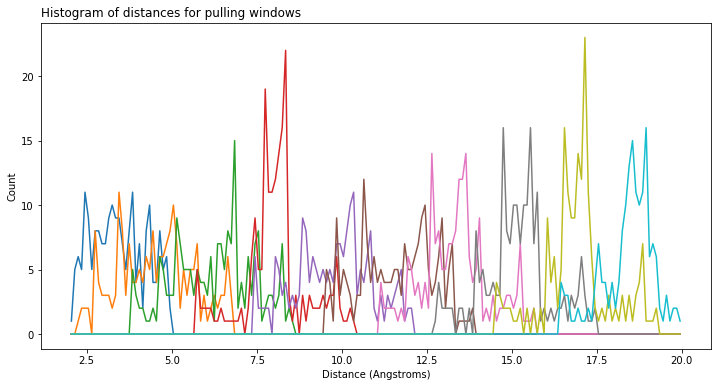

In [18]:
fig, ax = plt.subplots(1, figsize=(6 * 2, 6))
for window in sorted(glob.glob(windows_directory + "/p*")):
    trajectory = pt.iterload(os.path.join(window, free_energy.trajectory),
                             os.path.join(window, free_energy.prmtop))
    distance = pt.distance(trajectory, " ".join([restraint.mask1, restraint.mask2]))
    hist, bin_edges = np.histogram(distance, range=(2, 20), bins=180)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.plot(bin_centers, hist)
    ax.set_ylabel("Count")
    ax.set_xlabel("Distance (Angstroms)")
    ax.set_title("Histogram of distances for pulling windows", loc="left")

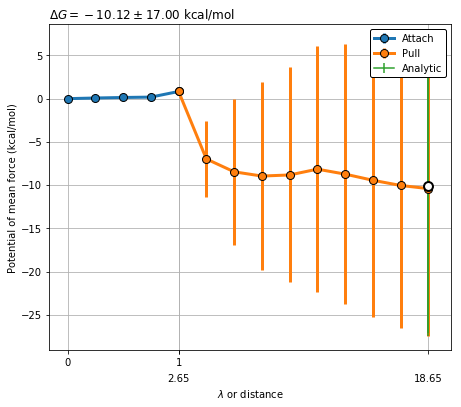

In [19]:
plot_pmf(attach=free_energy.results["attach"]["ti-block"]["fe_matrix"][0],
         pull=free_energy.results["pull"]["ti-block"]["fe_matrix"][0],
         release=None,
         release_to_std=free_energy.results["ref_state_work"],
         attach_sem=free_energy.results["attach"]["ti-block"]["sem_matrix"][0],
         pull_sem=free_energy.results["pull"]["ti-block"]["sem_matrix"][0],
         pull_initial=2.65,
         pull_final=18.65)

## But what would a more realistic calculation look like?

This calculation took about 100x as long to run and is overkill, but is a reliable test of the method.

In [20]:
with open("amber-gold-standard.json", "r") as f:
        json_data = f.read()
gold_standard = json.loads(json_data, object_hook=io.json_numpy_obj_hook)

In [21]:
binding_affinity = -1 * (
    gold_standard["attach"]["ti-block"]["fe"]
    + gold_standard["pull"]["ti-block"]["fe"]
    + gold_standard["ref_state_work"]
)

sem = np.sqrt(
    gold_standard["attach"]["ti-block"]["sem"] ** 2
    + gold_standard["pull"]["ti-block"]["sem"] ** 2
)

print(
    f"The binding affinity for K+ (+1.3) and Cl- (-1.3) = {binding_affinity:0.2f} +/- {sem:0.2f} kcal/mol"
)

The binding affinity for K+ (+1.3) and Cl- (-1.3) = -1.84 +/- 0.10 kcal/mol


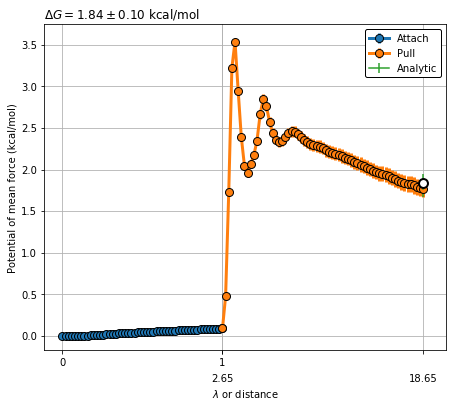

In [22]:
plot_pmf(attach=gold_standard["attach"]["ti-block"]["fe_matrix"][0],
         pull=gold_standard["pull"]["ti-block"]["fe_matrix"][0],
         release=None,
         release_to_std=gold_standard["ref_state_work"],
         attach_sem=gold_standard["attach"]["ti-block"]["sem_matrix"][0],
         pull_sem=gold_standard["pull"]["ti-block"]["sem_matrix"][0],
         pull_initial=2.65,
         pull_final=18.65)